# Consumer Behavior Analysis for Electric Vehicle Adoption using Digital Twins 

# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

# Modeling
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.cluster import KMeans

# Splitting data and model evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# Sampling
from imblearn.under_sampling import NearMiss
from collections import Counter

# Feature importance
import shap


# Load Dataset

In [3]:
data = pd.read_csv('Electric_Vehicle_Population_Data (2).csv')


In [4]:
data.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,244285107,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10
2,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,POINT (-122.34848 47.632405),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,POINT (-122.03646 47.534065),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,5YJYGDEE5M,Kitsap,Suquamish,WA,98392.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,23.0,205138552,POINT (-122.55717 47.733415),PUGET SOUND ENERGY INC,5.303594e+10


# Data Preprocessing


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177866 non-null  object 
 1   County                                             177861 non-null  object 
 2   City                                               177861 non-null  object 
 3   State                                              177866 non-null  object 
 4   Postal Code                                        177861 non-null  float64
 5   Model Year                                         177866 non-null  int64  
 6   Make                                               177866 non-null  object 
 7   Model                                              177866 non-null  object 
 8   Electric Vehicle Type                              177866 non-null  object

In [6]:
# initialize category and numeric data
category = [i for i in data.columns if data[i].dtype == 'object']
#numerical = [i for i in data.columns if data[i].dtype != 'object']

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Postal Code,177861.0,9.817245e+04,2.442451e+03,1.545000e+03,9.805200e+04,9.812200e+04,9.837000e+04,9.957700e+04
Model Year,177866.0,2.020516e+03,2.989384e+00,1.997000e+03,2.019000e+03,2.022000e+03,2.023000e+03,2.024000e+03
Electric Range,177866.0,5.884216e+01,9.198130e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.500000e+01,3.370000e+02
Base MSRP,177866.0,1.073109e+03,8.358625e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.450000e+05
Legislative District,177477.0,2.912748e+01,1.489217e+01,1.000000e+00,1.800000e+01,3.300000e+01,4.200000e+01,4.900000e+01
DOL Vehicle ID,177866.0,2.202313e+08,7.584987e+07,4.385000e+03,1.814743e+08,2.282522e+08,2.548445e+08,4.792548e+08
2020 Census Tract,177861.0,5.297672e+10,1.578047e+09,1.001020e+09,5.303301e+10,5.303303e+10,5.305307e+10,5.603300e+10


In [8]:
# show statistical summary of category data
data[category].describe().T

,count,unique,top,freq
VIN (1-10),177866,10830,7SAYGDEE6P,1239
County,177861,196,King,92740
City,177861,723,Seattle,29447
State,177866,46,WA,177477
Make,177866,40,TESLA,79659
Model,177866,139,MODEL Y,35989
Electric Vehicle Type,177866,2,Battery Electric Vehicle (BEV),139210
Clean Alternative Fuel Vehicle (CAFV) Eligibility,177866,3,Eligibility unknown as battery range has not b...,91950
Vehicle Location,177857,861,POINT (-122.12302 47.67668),4574
Electric Utility,177861,76,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),65990


In [103]:
# Checking the data shape
shape_of_data = data.shape
print(shape_of_data)

(177861, 955)


# MIssing Values

In [10]:
# show missing values of data
data.isnull().sum()

VIN (1-10)                                             0
County                                                 5
City                                                   5
State                                                  0
Postal Code                                            5
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 389
DOL Vehicle ID                                         0
Vehicle Location                                       9
Electric Utility                                       5
2020 Census Tract                                      5
dtype: int64

In [11]:
# Null values checking
data.isna()
data.isna().sum()
data.isna().sum()/len(data)*100
data.isna().sum()/len(data)*1000

VIN (1-10)                                           0.000000
County                                               0.028111
City                                                 0.028111
State                                                0.000000
Postal Code                                          0.028111
Model Year                                           0.000000
Make                                                 0.000000
Model                                                0.000000
Electric Vehicle Type                                0.000000
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0.000000
Electric Range                                       0.000000
Base MSRP                                            0.000000
Legislative District                                 2.187040
DOL Vehicle ID                                       0.000000
Vehicle Location                                     0.050600
Electric Utility                                     0.028111
2020 Cen

In [12]:
# Duplicat values check
Checking_duplicate_values=data.duplicated().sum()
print(f'The data set contains the {Checking_duplicate_values} values')

The data set contains the 0 values


In [13]:
# drop the missing values on the subset County and City
data.dropna(subset=['County', 'City'], inplace=True)

# show missing values of data
data.isnull().sum()

VIN (1-10)                                             0
County                                                 0
City                                                   0
State                                                  0
Postal Code                                            0
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 384
DOL Vehicle ID                                         0
Vehicle Location                                       4
Electric Utility                                       0
2020 Census Tract                                      0
dtype: int64

## Imputation

In [14]:
# define a procudure to impute missing values for numeric data
def impute_numeric_data(data, columns, mode):
    for col in columns:
        if mode == 'median':
            value = data[col].median()
        elif mode == 'mean':
            value = data[col].mean()
        data[col].fillna(value, inplace=True)

# define a procudure to impute missing values for category data
def impute_categoric_data(data, columns):
    for col in columns:
        mode_value = data[col].mode().iloc[0]
        data[col].fillna(mode_value, inplace=True)
        
# apply imputation procedure for numeric and category data        
impute_numeric_data(data, ['Legislative District'], 'median')
impute_categoric_data(data, ['Model', 'Vehicle Location'])

# show missing values of data
data.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

## Feature Engineering

In [15]:
# update values in 'Electric Vehicle Type' column
data['Electric Vehicle Type'] = data['Electric Vehicle Type'].apply(lambda x: \
                                                                x.replace('Plug-in Hybrid Electric Vehicle (PHEV)', 'PHEV')
                                                                .replace('Battery Electric Vehicle (BEV)', 'BEV'))

# rename column 'Clean Alternative Fuel Vehicle (CAFV) Eligibility' to 'Clean Alternative Fuel Vehicle Eligibility'
data.rename(columns={'Clean Alternative Fuel Vehicle (CAFV) Eligibility': 'Clean Alternative Fuel Vehicle Eligibility'}, inplace=True)

# define a function to extract longitude and latitude from 'Vehicle Location' column
def extract_coordinates(point_string):
    coordinates = point_string.replace('POINT', '').replace('(', '').replace(')', '')
    longitude, latitude = coordinates.split()
    return float(longitude), float(latitude)

# apply the 'extract_coordinates' function to 'Vehicle Location' column and create new 'Longitude' and 'Latitude' columns
data[['Longitude', 'Latitude']] = data['Vehicle Location'].apply(extract_coordinates).apply(pd.Series)
data = data.drop('Vehicle Location', axis=1)

# define a function to map state codes to state names
def state_mapping(state_code):
    state_mapping = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
        'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
        'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
        'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
        'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
        'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
        'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
        'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
        'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
        'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
        'WI': 'Wisconsin', 'WY': 'Wyoming'
    }
    
    return state_mapping.get(state_code, 'Unknown')

# apply the 'state_mapping' function to 'State' column
data['State'] = data['State'].apply(state_mapping)

# define a function to extract the first substring from a column
def extract_substring(data, column_name):
    data[column_name] = data[column_name].str.split('-|\\|').str[0].str.strip()

# apply the 'extract_substring' function to 'Electric Utility' column
extract_substring(data, 'Electric Utility')

In [16]:
data.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,5YJYGDEE1L,King,Seattle,Washington,98122.0,2020,TESLA,MODEL Y,BEV,Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,CITY OF SEATTLE,5.303301e+10,-122.308390,47.610365
1,7SAYGDEE9P,Snohomish,Bothell,Washington,98021.0,2023,TESLA,MODEL Y,BEV,Eligibility unknown as battery range has not b...,0,0,1.0,244285107,PUGET SOUND ENERGY INC,5.306105e+10,-122.179458,47.802589
2,5YJSA1E4XK,King,Seattle,Washington,98109.0,2019,TESLA,MODEL S,BEV,Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,CITY OF SEATTLE,5.303301e+10,-122.348480,47.632405
3,5YJSA1E27G,King,Issaquah,Washington,98027.0,2016,TESLA,MODEL S,BEV,Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,PUGET SOUND ENERGY INC,5.303303e+10,-122.036460,47.534065
4,5YJYGDEE5M,Kitsap,Suquamish,Washington,98392.0,2021,TESLA,MODEL Y,BEV,Eligibility unknown as battery range has not b...,0,0,23.0,205138552,PUGET SOUND ENERGY INC,5.303594e+10,-122.557170,47.733415


In [17]:
data.shape

(177861, 18)

# EDA

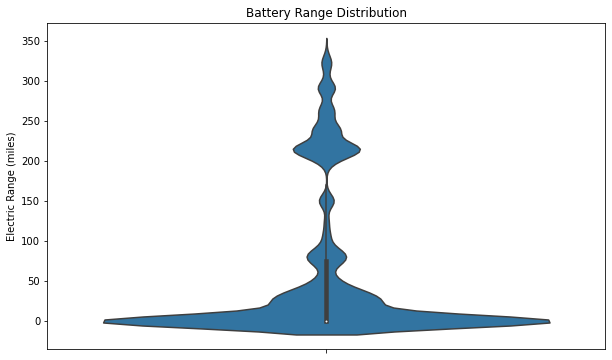

In [18]:
# Visualizing Battery Range using Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data, y='Electric Range')
plt.title('Battery Range Distribution')
plt.ylabel('Electric Range (miles)')
plt.show()

In [19]:
# Selecting only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

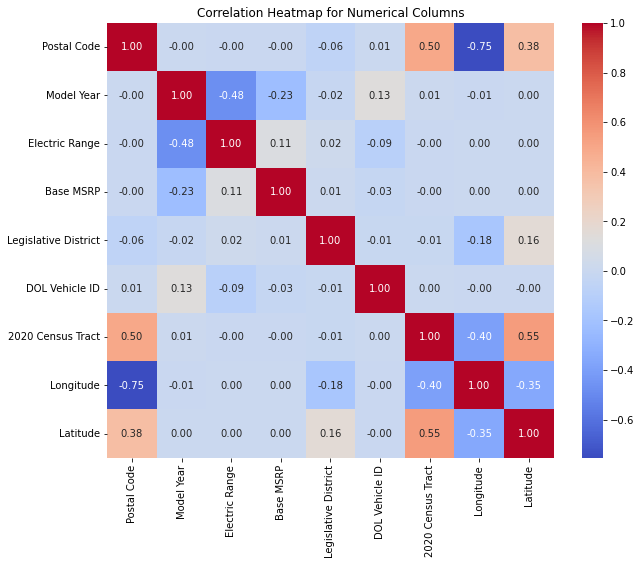

In [20]:
# Heatmap for Correlation with all numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()

In [21]:
column_names = data.columns
print("Column names of EV DataFrame:", column_names)

Column names of EV DataFrame: Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Electric Utility', '2020 Census Tract', 'Longitude', 'Latitude'],
      dtype='object')


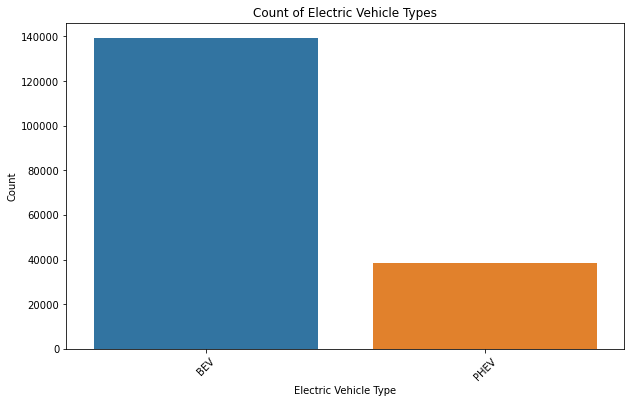

In [22]:
# Count of each Electric Vehicle Type
plt.figure(figsize=(10, 6))
sns.countplot(x='Electric Vehicle Type', data=data)
plt.title('Count of Electric Vehicle Types')
plt.xlabel('Electric Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

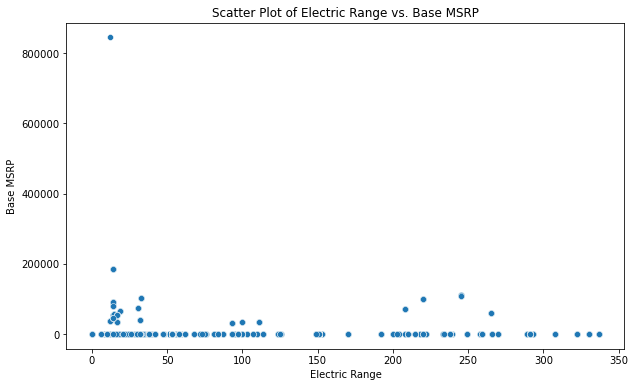

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Electric Range', y='Base MSRP', data=data)
plt.title('Scatter Plot of Electric Range vs. Base MSRP')
plt.xlabel('Electric Range')
plt.ylabel('Base MSRP')
plt.show()

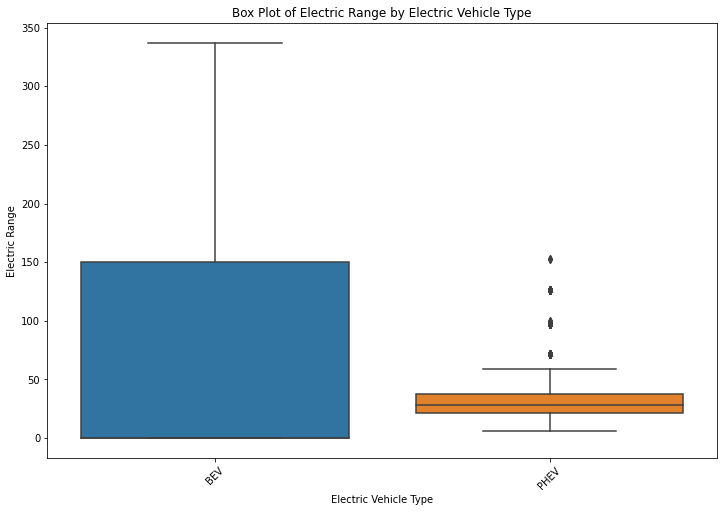

In [24]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Electric Vehicle Type', y='Electric Range', data=data)
plt.title('Box Plot of Electric Range by Electric Vehicle Type')
plt.xlabel('Electric Vehicle Type')
plt.ylabel('Electric Range')
plt.xticks(rotation=45)
plt.show()

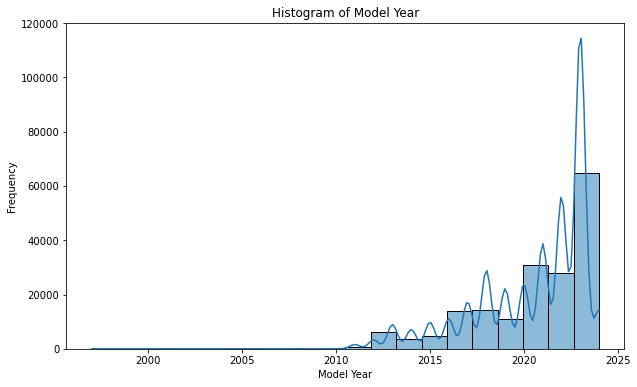

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Model Year'], bins=20, kde=True)
plt.title('Histogram of Model Year')
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.show()

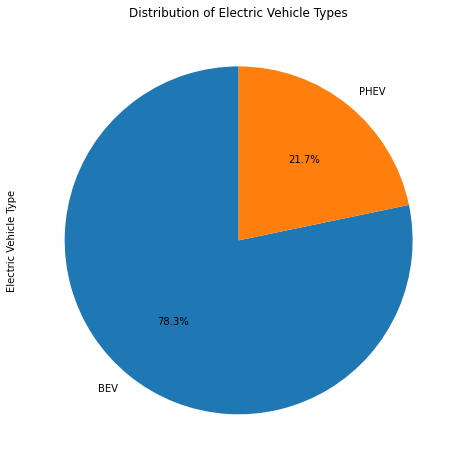

In [26]:
plt.figure(figsize=(8, 8))
data['Electric Vehicle Type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Electric Vehicle Types')
plt.show()

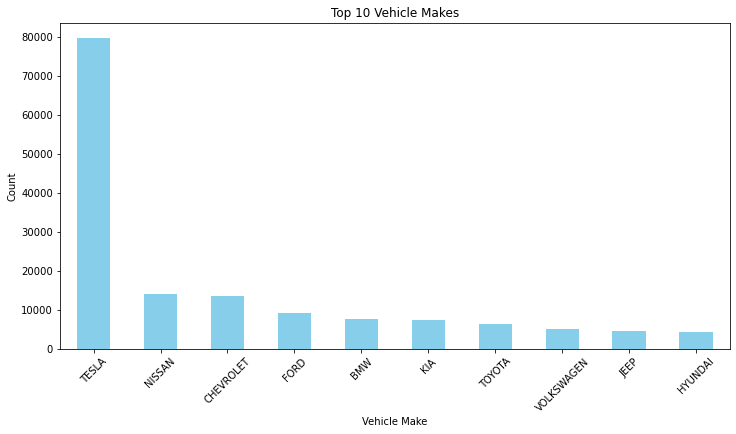

In [27]:
plt.figure(figsize=(12, 6))
top_makes = data['Make'].value_counts().nlargest(10)
top_makes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Vehicle Makes')
plt.xlabel('Vehicle Make')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

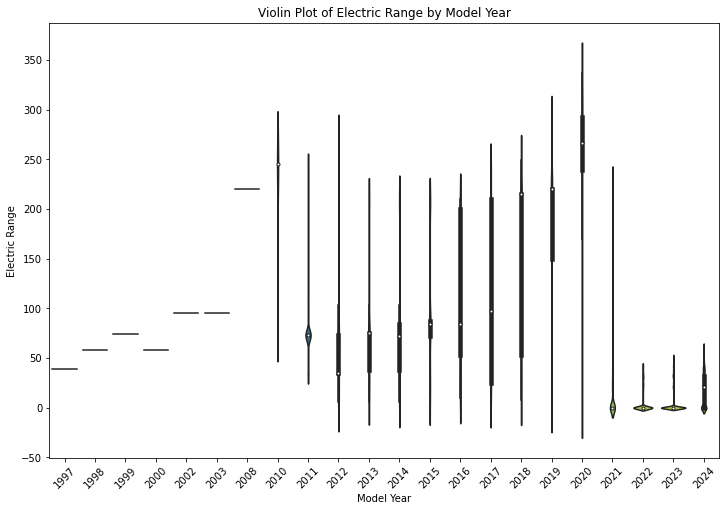

In [28]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Model Year', y='Electric Range', data=data, palette='viridis')
plt.title('Violin Plot of Electric Range by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Electric Range')
plt.xticks(rotation=45)
plt.show()

In [29]:
# Cleaning Null Values
data.dropna(inplace=True)

# Checking Duplicate Value
data.duplicated().sum()

# Removing Column
data['State'].value_counts()

# State column has only one value i.e WA means Washington D.C. So we can remove 'state' column
data.drop(columns='State',inplace=True)

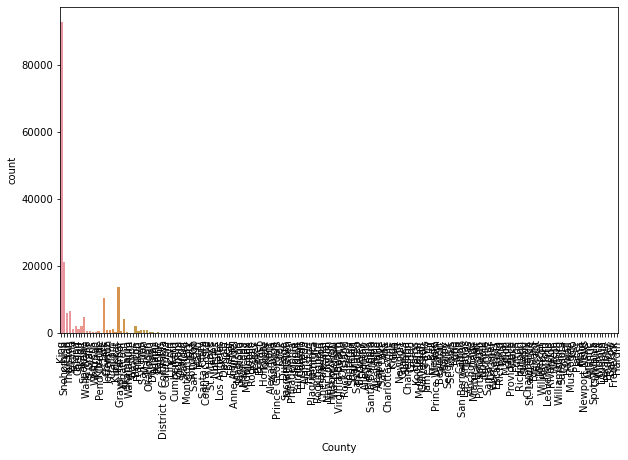

In [30]:
plt.figure(figsize=(10,6))
sns.countplot(x='County',data=data)
plt.xticks(rotation=90);

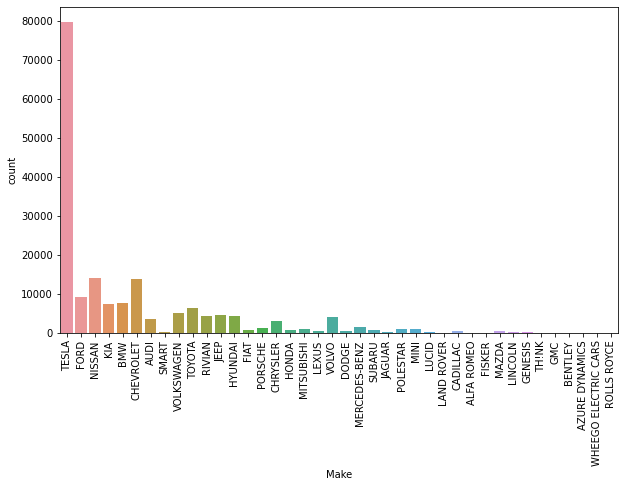

In [31]:
plt.figure(figsize=(10,6))
sns.countplot(x='Make',data=data)
plt.xticks(rotation=90);

<AxesSubplot:ylabel='Electric Vehicle Type'>

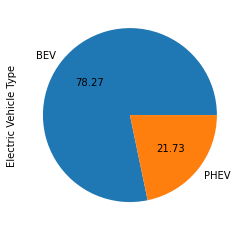

In [32]:
data['Electric Vehicle Type'].value_counts().plot(kind='pie',autopct='%.2f')

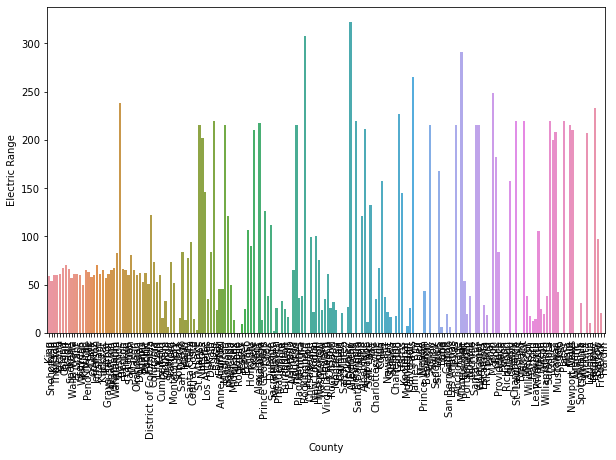

In [33]:
# Bivariate Analysis
plt.figure(figsize=(10,6))
sns.barplot(x='County',y='Electric Range',data=data,ci=None)
plt.xticks(rotation=90);

<AxesSubplot:xlabel='Electric Vehicle Type', ylabel='Electric Range'>

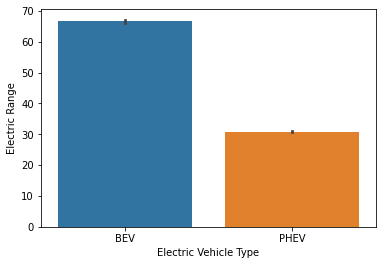

In [34]:
sns.barplot(x='Electric Vehicle Type',y='Electric Range',data=data)

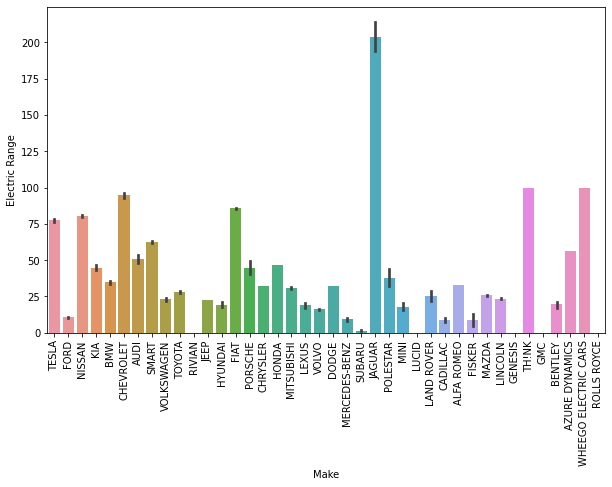

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(x='Make',y='Electric Range',data=data)
plt.xticks(rotation=90);

<AxesSubplot:xlabel='Model Year', ylabel='Electric Range'>

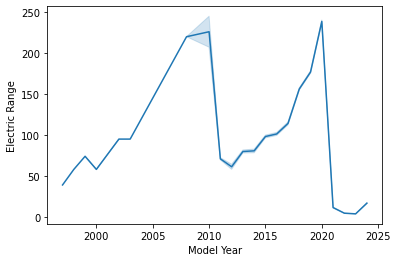

In [36]:
sns.lineplot(x='Model Year',y='Electric Range',data=data)

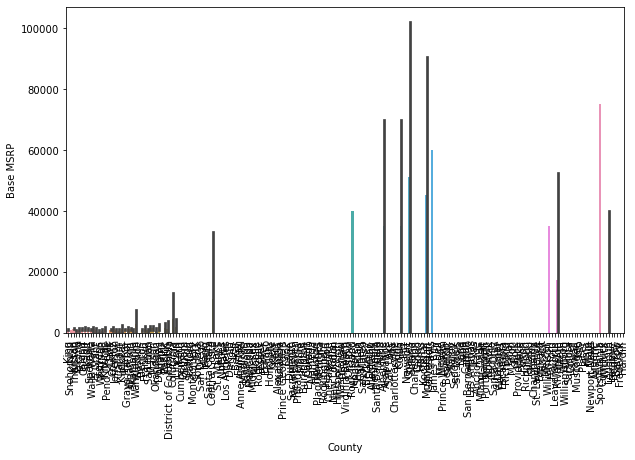

In [37]:
plt.figure(figsize=(10,6))
sns.barplot(x='County',y='Base MSRP',data=data)
plt.xticks(rotation=90);

<AxesSubplot:xlabel='Electric Vehicle Type', ylabel='Base MSRP'>

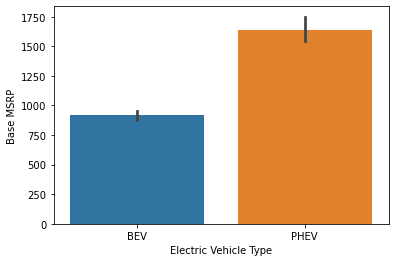

In [38]:
sns.barplot(x='Electric Vehicle Type',y='Base MSRP',data=data)

In [39]:
# Q1:Which counties and cities in Washington State have the highest electric vehicle registrations?
# Lets start by grouping our data according to Cities and Counties since our dataset online include eletric vehicles only
county_city_registrations = data.groupby(['County', 'City']).size().reset_index(name='Registrations')
county_city_registrations.head(2)

,County,City,Registrations
0,Ada,Boise,2
1,Adams,Aurora,1


In [40]:
# Then we need to arrange the grouped data in Descending order
highest_registrations = county_city_registrations.sort_values(by='Registrations', ascending=False)
highest_registrations.head(2)

,County,City,Registrations
277,King,Seattle,29447
244,King,Bellevue,8930


In [41]:
# What are the most popular electric vehicle makes and models in Washington State?
# To identify the most popular electric vehicle makes and models in Washington State based on the provided dataset columns, you 
# can follow these steps: Group the data by "Make" and "Model" columns to aggregate registrations for each combination.

make_model_distribution = data.groupby(['Make', 'Model']).size().reset_index(name='Registrations')
make_model_distribution.head(2)

,Make,Model,Registrations
0,ALFA ROMEO,TONALE,39
1,AUDI,A3,548


In [42]:
# Sort the DataFrame in descending order based on the number of registrations to identify the most popular electric vehicle makes and models.
popular_make_model = make_model_distribution.sort_values(by='Registrations', ascending=False)
popular_make_model.head(2)

,Make,Model,Registrations
120,TESLA,MODEL Y,35989
117,TESLA,MODEL 3,30091


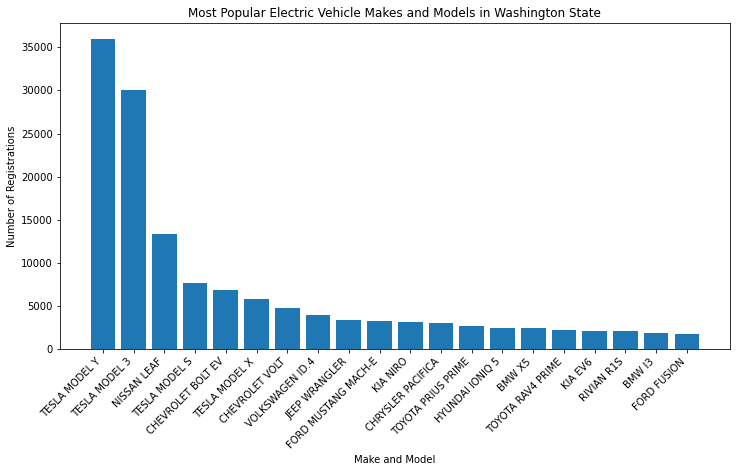

In [43]:
# Create visualizations, such as bar charts or tables, to illustrate the distribution of electric vehicle registrations across different makes and models.

x=popular_make_model.head(20)
plt.figure(figsize=(12, 6))
plt.bar(x['Make'] + ' ' + x['Model'], x['Registrations'])
plt.xlabel('Make and Model')
plt.ylabel('Number of Registrations')
plt.title('Most Popular Electric Vehicle Makes and Models in Washington State')
plt.xticks(rotation=45, ha='right')
plt.show()

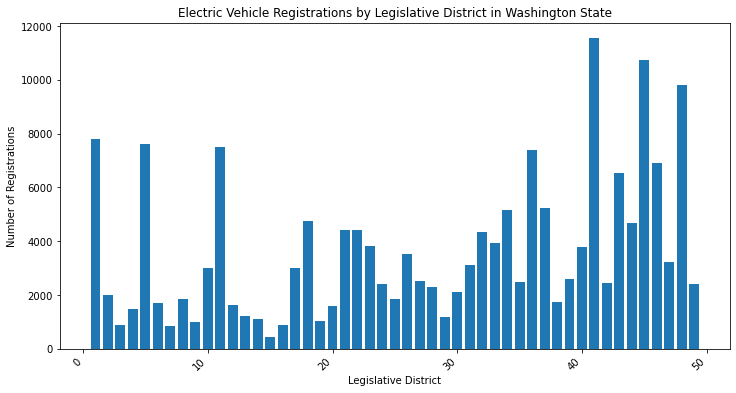

Correlation Coefficient: -0.05435021249664533


In [44]:
# Group by Legislative District
district_distribution = data.groupby('Legislative District').size().reset_index(name='Registrations')

# Sort by Registrations
popular_districts = district_distribution.sort_values(by='Registrations', ascending=False)

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(popular_districts['Legislative District'], popular_districts['Registrations'])
plt.xlabel('Legislative District')
plt.ylabel('Number of Registrations')
plt.title('Electric Vehicle Registrations by Legislative District in Washington State')
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate and display the correlation coefficient
correlation_coefficient = data['Legislative District'].corr( popular_districts['Registrations'])
print(f"Correlation Coefficient: {correlation_coefficient}")

In [45]:
# Filter for electric vehicles that are eligible as CAFV

eligible_vehicles = data[data['Clean Alternative Fuel Vehicle Eligibility'] == 'Clean Alternative Fuel Vehicle Eligible']

# Calculate the percentage
percentage_eligible_vehicles = (len(eligible_vehicles) / len(data)) * 100

print(f"Percentage of Electric Vehicles Eligible as CAFV: {percentage_eligible_vehicles:.2f}%")

Percentage of Electric Vehicles Eligible as CAFV: 37.29%


In [46]:
data.head()

,VIN (1-10),County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,Latitude
0,5YJYGDEE1L,King,Seattle,98122.0,2020,TESLA,MODEL Y,BEV,Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,CITY OF SEATTLE,5.303301e+10,-122.308390,47.610365
1,7SAYGDEE9P,Snohomish,Bothell,98021.0,2023,TESLA,MODEL Y,BEV,Eligibility unknown as battery range has not b...,0,0,1.0,244285107,PUGET SOUND ENERGY INC,5.306105e+10,-122.179458,47.802589
2,5YJSA1E4XK,King,Seattle,98109.0,2019,TESLA,MODEL S,BEV,Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,CITY OF SEATTLE,5.303301e+10,-122.348480,47.632405
3,5YJSA1E27G,King,Issaquah,98027.0,2016,TESLA,MODEL S,BEV,Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,PUGET SOUND ENERGY INC,5.303303e+10,-122.036460,47.534065
4,5YJYGDEE5M,Kitsap,Suquamish,98392.0,2021,TESLA,MODEL Y,BEV,Eligibility unknown as battery range has not b...,0,0,23.0,205138552,PUGET SOUND ENERGY INC,5.303594e+10,-122.557170,47.733415


In [47]:
from sklearn.preprocessing import LabelEncoder

# Now you can use LabelEncoder
label_encoder = LabelEncoder()
data['Electric Vehicle Type'] = label_encoder.fit_transform(data['Electric Vehicle Type'])
data['Make'] = label_encoder.fit_transform(data['Make'])


In [48]:

# Encoding categorical variables
label_encoder = LabelEncoder()
data['Electric Vehicle Type'] = label_encoder.fit_transform(data['Electric Vehicle Type'])
data['Make'] = label_encoder.fit_transform(data['Make'])
data['Model'] = label_encoder.fit_transform(data['Model'])


In [49]:
# Split the data into features (X) and target variable (y)
#X = data[['Electric Range', 'Base MSRP', 'Electric Vehicle Type', 'Make', 'Model']]
#y = data['Model']


In [50]:
# Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Drop irrelevant columns
data.drop("VIN (1-10)", axis=1, inplace=True)


In [96]:
data[['Postal Code', 'Model Year', 'Make', 'Model', 'Electric Range', 'Base MSRP']]

,Postal Code,Model Year,Make,Model,Electric Range,Base MSRP
0,98122.0,2020,34,81,291,0
1,98021.0,2023,34,81,0,0
2,98109.0,2019,34,79,270,0
3,98027.0,2016,34,79,210,0
4,98392.0,2021,34,81,0,0
...,...,...,...,...,...,...
177861,98391.0,2022,34,81,0,0
177862,98584.0,2023,15,75,0,0
177863,98848.0,2021,34,81,0,0
177864,98010.0,2021,37,68,0,0


In [95]:
print(data.columns[:0])

Index([], dtype='object')


## Train Test Splitting

In [82]:

#sns.set_theme(style="white")
 
X = data[['Postal Code', 'Model Year', 'Make', 'Model', 'Electric Range', 'Base MSRP']].values
y = data['Electric Vehicle Type'].values


# split the data into train and test sets with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=21)

In [83]:
# count the occurrences of target value in the 'Electric Vehicle Type' column
data['Electric Vehicle Type'].value_counts()

0    139205
1     38656
Name: Electric Vehicle Type, dtype: int64

## Naive Bayes

In [84]:
# initialize the Naive Bayes classifier and fit it to the resampled training data
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train)

# make predictions on the test data
y_pred = NB_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.896437339530351
ROC AUC Score: 0.8193302711926629
Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.96      0.94     41762
           1       0.81      0.68      0.74     11597

    accuracy                           0.90     53359
   macro avg       0.86      0.82      0.84     53359
weighted avg       0.89      0.90      0.89     53359

Confusion Matrix:

 [[39913  1849]
 [ 3677  7920]]


## Logistic Regression

In [90]:
# initialize the Logistic Regression classifier and fit it to the resampled training data
LR_classifier = LogisticRegression()
LR_classifier.fit(X_train, y_train)

# make predictions on the test data
y_pred = LR_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.834423433722521
ROC AUC Score: 0.6884668793554423
Classification Report:

               precision    recall  f1-score   support

           0       0.86      0.95      0.90     41762
           1       0.69      0.43      0.53     11597

    accuracy                           0.83     53359
   macro avg       0.77      0.69      0.71     53359
weighted avg       0.82      0.83      0.82     53359

Confusion Matrix:

 [[39534  2228]
 [ 6607  4990]]


# Random Forest Classifier

In [98]:
# initialize the Random Forest classifier and fit it to the resampled training data
RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(X_train, y_train)

# make predictions on the test data
y_pred = RF_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
accurary = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Accuracy     :", accurary)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Accuracy     : 0.9999062950954853
ROC AUC Score: 0.9998155689989119
Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     41762
           1       1.00      1.00      1.00     11597

    accuracy                           1.00     53359
   macro avg       1.00      1.00      1.00     53359
weighted avg       1.00      1.00      1.00     53359

Confusion Matrix:

 [[41761     1]
 [    4 11593]]
